In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.6f' % x) #为了直观的显示数字，不采用科学计数法
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import numpy as np
np.set_printoptions(suppress = True)
import scipy
import os
import math
import time
import random
import joblib
from joblib import Parallel, delayed
import warnings
from tqdm.notebook import tqdm
import gc

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
try:
    physical_devices = tf.config.list_physical_devices('GPU') 
    print('GPUs: %s' % physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except Exception as e:
    print('貌似可能没有GPU')
tf.keras.backend.set_floatx('float32')

GPUs: []
貌似可能没有GPU


In [2]:
# 模型应用场景配置，目前可配置 ：base_types = ['4g', '5g']
# kpis = ['PDCCH', 'PDCPDL', 'PDCPUL', 'PDSCH', 'PUSCH', 'RRC']
data_folder = '../../preprocessed_data/final/'
folders = os.listdir(data_folder)
folders
base_types = ['4g', '5g']
kpis = ['PDCCH', 'PDCPDL', 'PDCPUL', 'PDSCH', 'PUSCH', 'RRC']

['5g_PDCPUL',
 '5g_PDSCH',
 '5g_RRC',
 '4g_PDCPDL',
 '4g_PDCPUL',
 '4g_RRC',
 '.ipynb_checkpoints',
 '4g_PDSCH',
 '5g_PDCPDL',
 '4g_PDCCH',
 '5g_PUSCH',
 '4g_PUSCH',
 '5g_PDCCH']

In [4]:
input_periods = 24 * 21
n_features = 28
input_cols = ['is_holiday_%s' % i for i in range(n_features)] + ['input_%s' % i for i in range(input_periods)]
output_periods = 24 * 7
output_cols = ['output_%s' % i for i in range(output_periods)]

def custom_mape(y_actual, y_pred):
    absolute_error = tf.abs(y_actual - y_pred)
    absolute_precentage_error = absolute_error / y_actual * 100.
    
    mean_by_row = tf.reshape(tf.reduce_mean(y_actual, axis=1), (-1, 1))
    unified_absolute_error = absolute_error / mean_by_row * 100.
    
    combined_error = tf.where(absolute_precentage_error <= 100., absolute_precentage_error, 2 * unified_absolute_error)
    return tf.reduce_mean(combined_error) ** 2

default_lr = 0.0005

def build_compile_model(loss, use_output_relu=False):
    input_ = keras.Input(shape=n_features + input_periods)
    mean_by_row = tf.reshape(tf.reduce_mean(input_[:, n_features:], axis=1), (-1, 1))
    normalized_input = tf.concat([input_[:, :n_features], input_[:, n_features:] / mean_by_row], axis=1)
    hidden_1 = tf.nn.relu(layers.Dense(4096, use_bias=True)(normalized_input))
    hidden_2 = tf.nn.relu(layers.Dense(4096, use_bias=True)(normalized_input) + layers.Dense(4096, use_bias=True)(hidden_1)) / 2.
    output = (layers.Dense(output_periods, use_bias=True)(normalized_input) + layers.Dense(output_periods, use_bias=True)(hidden_1)
              + layers.Dense(output_periods, use_bias=True)(hidden_2)) / 3.
    output *= mean_by_row
    if use_output_relu:
        output = tf.nn.relu(output)
    model = keras.Model(input_, output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=default_lr)
    model.compile(optimizer, loss)
    return model

# batch size和epochs
training_params = {
    'PDCCH': (8192, 128),
    'PDCPDL': (16384, 128),
    'PDCPUL': (16384, 128),
    'PDSCH': (8192, 128),
    'PUSCH': (8192, 128),
    'RRC': (8192, 128)
}

def train(model, folder, kpi):
    print('reading data')
    train_df = pd.read_pickle(os.path.join(folder, 'regression_train_data.pkl'))
    print('extracting training array')
    train_x, train_y = train_df.loc[:, input_cols].values.astype(np.float32), train_df.loc[:, output_cols].values.astype(np.float32)
    del train_df; gc.collect()
    batch_size, epochs = training_params[kpi]
    def scheduler(epoch, lr):
        return lr - default_lr / epochs
    callback = keras.callbacks.LearningRateScheduler(scheduler)
    model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, callbacks=[callback])
    del train_x, train_y; gc.collect()

In [5]:
for kpi in kpis:
    print('building model for %s' % kpi)
    model = build_compile_model(custom_mape, False)
    print('training model for %s' % kpi)
    train(model, os.path.join(data_folder, '%s_%s' % ('4g', kpi)), kpi)
    print('saving model for %s' % kpi)
    model.save('models/4g_%s.h5' % kpi)
    del model; gc.collect() # 这个似乎是必须的。

building model for PDCCH
training model for PDCCH
reading data
extracting training array
Train on 1898550 samples
Epoch 1/128
1898550/1898550 [==============================] - 25s 13us/sample - loss: 17047.1915
Epoch 2/128
1898550/1898550 [==============================] - 22s 12us/sample - loss: 32547.7288
Epoch 3/128
1898550/1898550 [==============================] - 22s 12us/sample - loss: 13677.7874
Epoch 4/128
1898550/1898550 [==============================] - 22s 12us/sample - loss: 9704.2294
Epoch 5/128
1898550/1898550 [==============================] - 22s 12us/sample - loss: 8664.1305
Epoch 6/128
1898550/1898550 [==============================] - 22s 11us/sample - loss: 4275.0534
Epoch 7/128
1898550/1898550 [==============================] - 22s 12us/sample - loss: 3034.3813
Epoch 8/128
1898550/1898550 [==============================] - 22s 11us/sample - loss: 2040.9966
Epoch 9/128
1898550/1898550 [==============================] - 22s 11us/sample - loss: 1351.9088
Epoch 10/1

7888

building model for PDCPDL
training model for PDCPDL
reading data
extracting training array
Train on 1898580 samples
Epoch 1/128
1898580/1898580 [==============================] - 25s 13us/sample - loss: 1823.9694
Epoch 2/128
1898580/1898580 [==============================] - 22s 12us/sample - loss: 1080.8248
Epoch 3/128
1898580/1898580 [==============================] - 22s 11us/sample - loss: 1003.8091
Epoch 4/128
1898580/1898580 [==============================] - 23s 12us/sample - loss: 964.4942
Epoch 5/128
1898580/1898580 [==============================] - 21s 11us/sample - loss: 991.7232
Epoch 6/128
1898580/1898580 [==============================] - 22s 12us/sample - loss: 934.6350
Epoch 7/128
1898580/1898580 [==============================] - 21s 11us/sample - loss: 878.2135
Epoch 8/128
1898580/1898580 [==============================] - 21s 11us/sample - loss: 872.4278
Epoch 9/128
1898580/1898580 [==============================] - 22s 12us/sample - loss: 894.7747
Epoch 10/128
1898

7888

building model for PDCPUL
training model for PDCPUL
reading data
extracting training array
Train on 1898400 samples
Epoch 1/128
1898400/1898400 [==============================] - 23s 12us/sample - loss: 2156.3910
Epoch 2/128
1898400/1898400 [==============================] - 21s 11us/sample - loss: 1413.6690
Epoch 3/128
1898400/1898400 [==============================] - 21s 11us/sample - loss: 1227.2590
Epoch 4/128
1898400/1898400 [==============================] - 21s 11us/sample - loss: 1190.3497
Epoch 5/128
1898400/1898400 [==============================] - 21s 11us/sample - loss: 1126.2848
Epoch 6/128
1898400/1898400 [==============================] - 21s 11us/sample - loss: 1119.9766
Epoch 7/128
1898400/1898400 [==============================] - 21s 11us/sample - loss: 1081.9251
Epoch 8/128
1898400/1898400 [==============================] - 21s 11us/sample - loss: 1153.1491
Epoch 9/128
1898400/1898400 [==============================] - 21s 11us/sample - loss: 1025.1442
Epoch 10/12

7888

building model for PDSCH
training model for PDSCH
reading data
extracting training array
Train on 1898460 samples
Epoch 1/128
1898460/1898460 [==============================] - 23s 12us/sample - loss: 1009.6492
Epoch 2/128
1898460/1898460 [==============================] - 22s 11us/sample - loss: 596.2124
Epoch 3/128
1898460/1898460 [==============================] - 22s 11us/sample - loss: 561.2490
Epoch 4/128
1898460/1898460 [==============================] - 21s 11us/sample - loss: 538.2457
Epoch 5/128
1898460/1898460 [==============================] - 21s 11us/sample - loss: 522.4557
Epoch 6/128
1898460/1898460 [==============================] - 21s 11us/sample - loss: 511.5364
Epoch 7/128
1898460/1898460 [==============================] - 21s 11us/sample - loss: 502.4455
Epoch 8/128
1898460/1898460 [==============================] - 21s 11us/sample - loss: 494.4677
Epoch 9/128
1898460/1898460 [==============================] - 21s 11us/sample - loss: 488.2855
Epoch 10/128
1898460/

7888

building model for PUSCH
training model for PUSCH
reading data
extracting training array
Train on 1898160 samples
Epoch 1/128
1898160/1898160 [==============================] - 22s 12us/sample - loss: 1604.1017
Epoch 2/128
1898160/1898160 [==============================] - 22s 11us/sample - loss: 1050.5468
Epoch 3/128
1898160/1898160 [==============================] - 21s 11us/sample - loss: 1003.4081
Epoch 4/128
1898160/1898160 [==============================] - 21s 11us/sample - loss: 1072.9236
Epoch 5/128
1898160/1898160 [==============================] - 21s 11us/sample - loss: 958.4660
Epoch 6/128
1898160/1898160 [==============================] - 22s 11us/sample - loss: 905.4271
Epoch 7/128
1898160/1898160 [==============================] - 22s 11us/sample - loss: 966.2610
Epoch 8/128
1898160/1898160 [==============================] - 22s 11us/sample - loss: 848.8530
Epoch 9/128
1898160/1898160 [==============================] - 21s 11us/sample - loss: 819.2306
Epoch 10/128
18981

7888

building model for RRC
training model for RRC
reading data
extracting training array
Train on 1898280 samples
Epoch 1/128
1898280/1898280 [==============================] - 22s 12us/sample - loss: 987.3737
Epoch 2/128
1898280/1898280 [==============================] - 22s 11us/sample - loss: 555.5483
Epoch 3/128
1898280/1898280 [==============================] - 22s 11us/sample - loss: 504.9928
Epoch 4/128
1898280/1898280 [==============================] - 22s 11us/sample - loss: 484.3250
Epoch 5/128
1898280/1898280 [==============================] - 22s 11us/sample - loss: 469.3540
Epoch 6/128
1898280/1898280 [==============================] - 22s 11us/sample - loss: 460.8271
Epoch 7/128
1898280/1898280 [==============================] - 22s 11us/sample - loss: 447.1557
Epoch 8/128
1898280/1898280 [==============================] - 22s 11us/sample - loss: 439.6779
Epoch 9/128
1898280/1898280 [==============================] - 22s 11us/sample - loss: 439.4709
Epoch 10/128
1898280/18982

7888

---

In [6]:
def plot_result(model, folder):
    train_df = pd.read_pickle(os.path.join(folder, 'regression_train_data.pkl')).sample(5)
    train_x = train_df.loc[:, input_cols].values.astype(np.float32)
    train_y = train_df.loc[:, output_cols].values.astype(np.float32)
    train_x_y = train_df.loc[:, input_cols[n_features:] + output_cols].values.astype(np.float32)
    predict = model.predict(train_x)
    for i in range(5):
        print('MAPE: %s' % (keras.losses.MeanAbsolutePercentageError()(train_y[i], predict[i])))
        _ = plt.figure(figsize=(20, 3))
#         _ = plt.scatter(np.arange(input_periods + output_periods), train_x_y[i], s=4)
#         _ = plt.scatter(np.arange(input_periods, input_periods + output_periods), predict[i], s=4)
        _ = plt.plot(np.arange(input_periods + output_periods), train_x_y[i])
        _ = plt.plot(np.arange(input_periods, input_periods + output_periods), predict[i])
        _ = plt.show()

showing plots for kpi PDCCH
MAPE: tf.Tensor(22.513672, shape=(), dtype=float32)


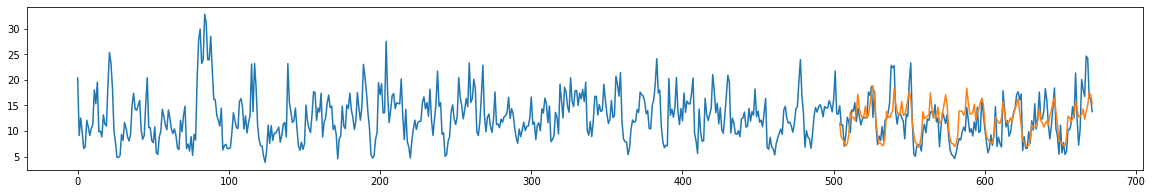

MAPE: tf.Tensor(11.967391, shape=(), dtype=float32)


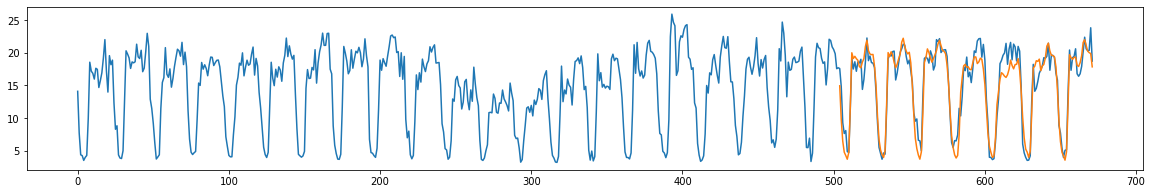

MAPE: tf.Tensor(12.020188, shape=(), dtype=float32)


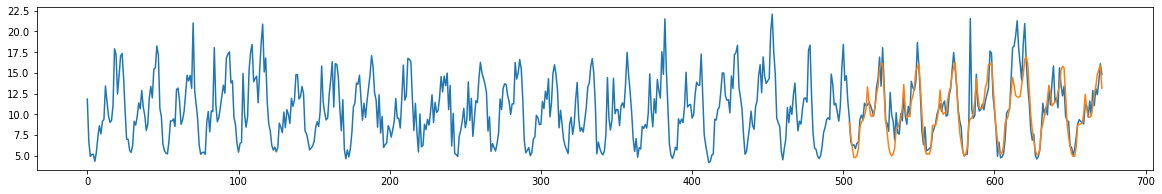

MAPE: tf.Tensor(4.9931774, shape=(), dtype=float32)


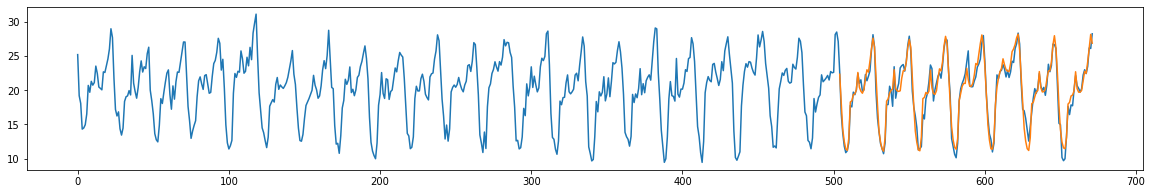

MAPE: tf.Tensor(9.941259, shape=(), dtype=float32)


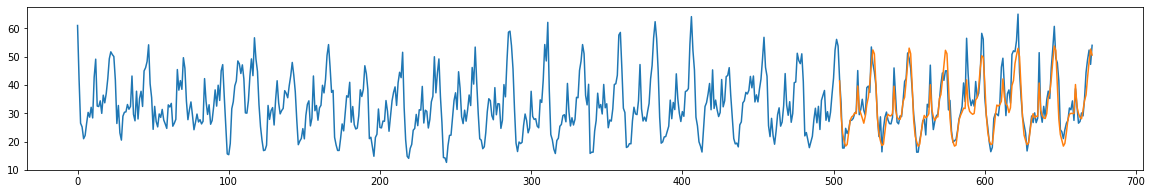

showing plots for kpi PDCPDL
MAPE: tf.Tensor(416.00494, shape=(), dtype=float32)


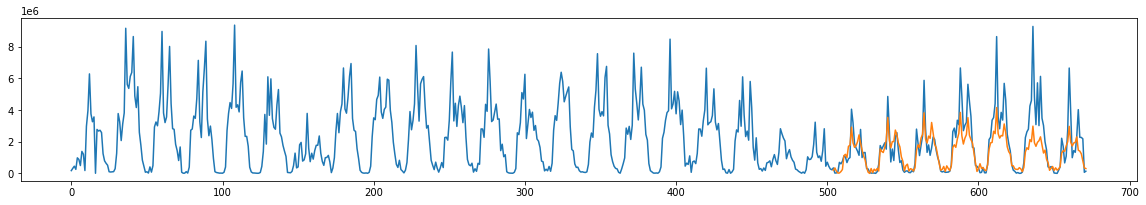

MAPE: tf.Tensor(26.95266, shape=(), dtype=float32)


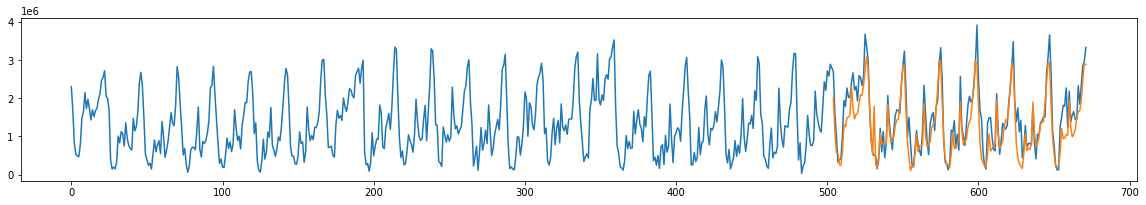

MAPE: tf.Tensor(28.193575, shape=(), dtype=float32)


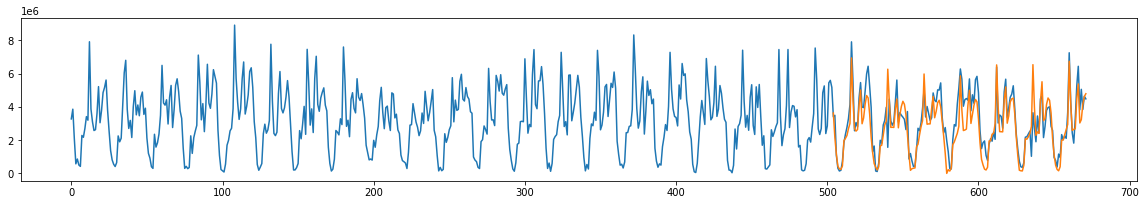

MAPE: tf.Tensor(32.818325, shape=(), dtype=float32)


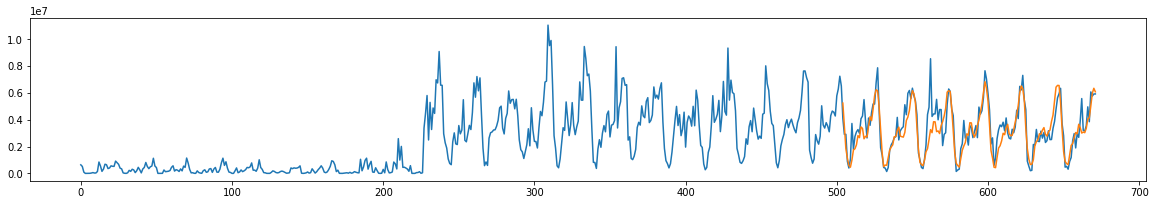

MAPE: tf.Tensor(37.113277, shape=(), dtype=float32)


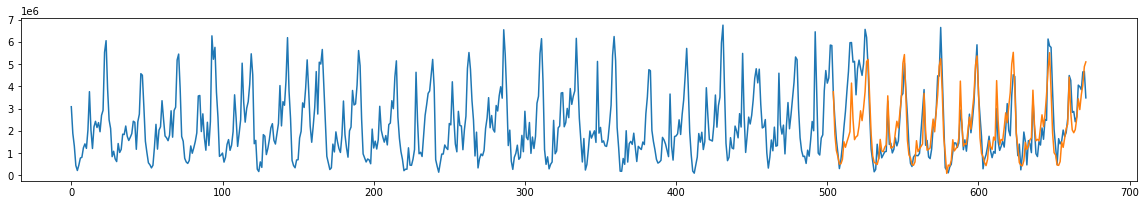

showing plots for kpi PDCPUL
MAPE: tf.Tensor(20.890942, shape=(), dtype=float32)


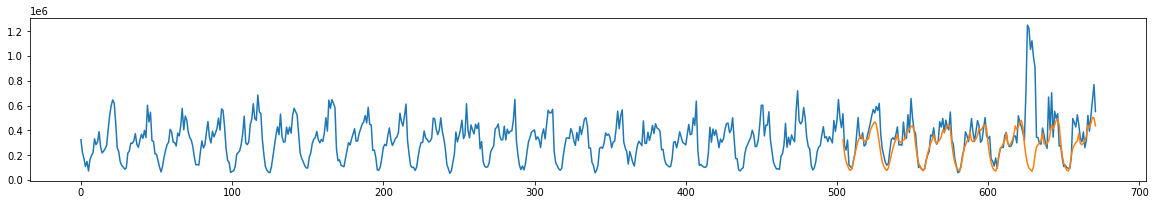

MAPE: tf.Tensor(25.025963, shape=(), dtype=float32)


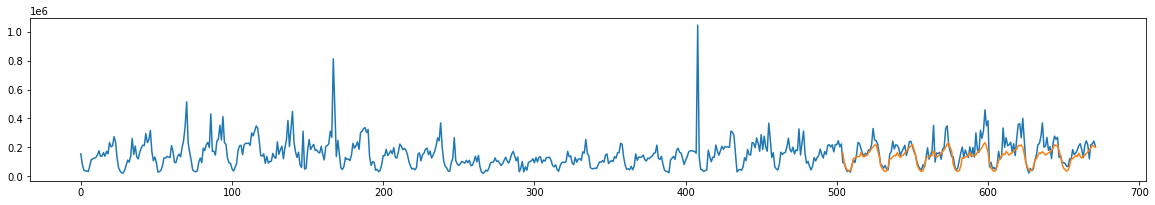

MAPE: tf.Tensor(7554.5396, shape=(), dtype=float32)


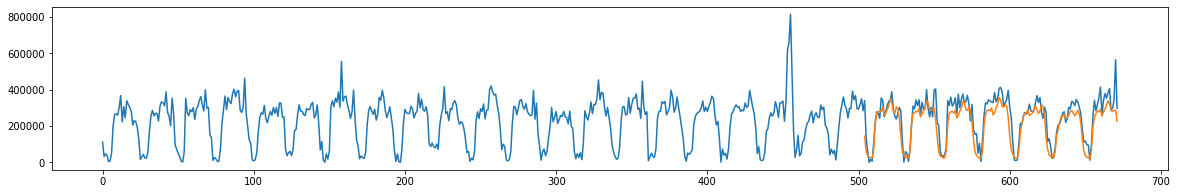

MAPE: tf.Tensor(27.919365, shape=(), dtype=float32)


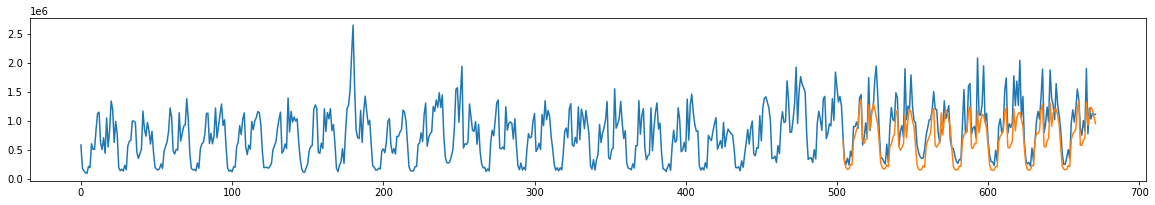

MAPE: tf.Tensor(26.961073, shape=(), dtype=float32)


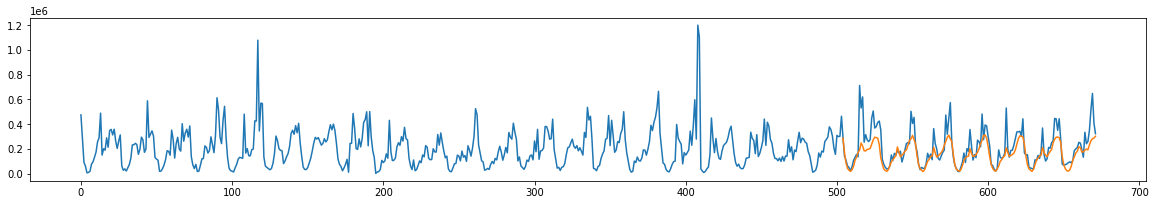

showing plots for kpi PDSCH
MAPE: tf.Tensor(18.584208, shape=(), dtype=float32)


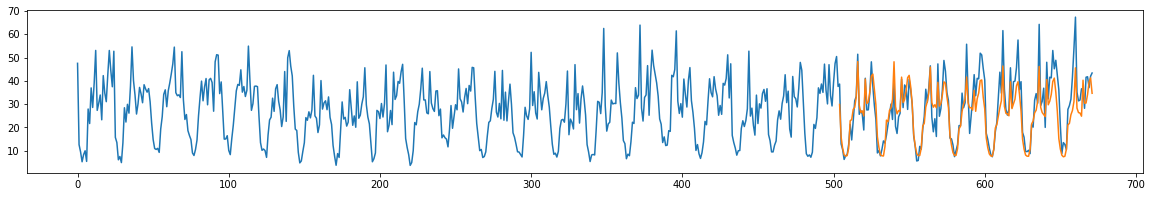

MAPE: tf.Tensor(16.837013, shape=(), dtype=float32)


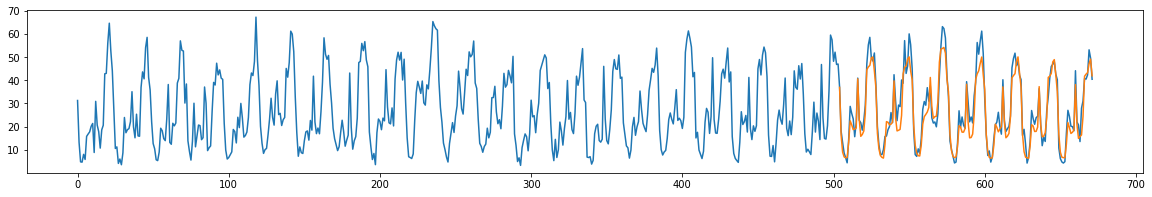

MAPE: tf.Tensor(137.80756, shape=(), dtype=float32)


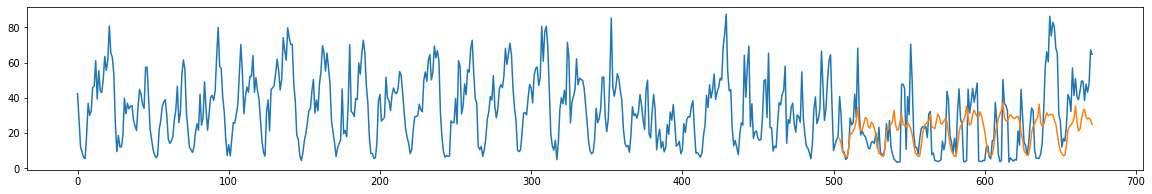

MAPE: tf.Tensor(21.890272, shape=(), dtype=float32)


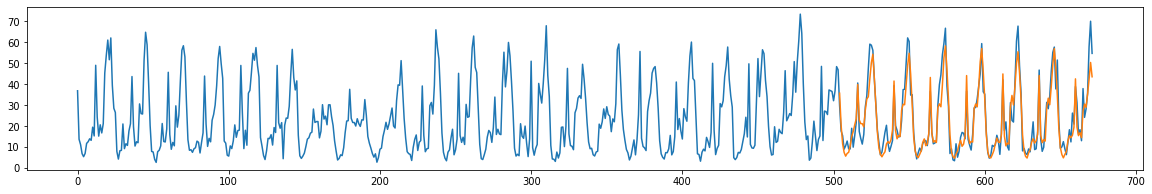

MAPE: tf.Tensor(20.43613, shape=(), dtype=float32)


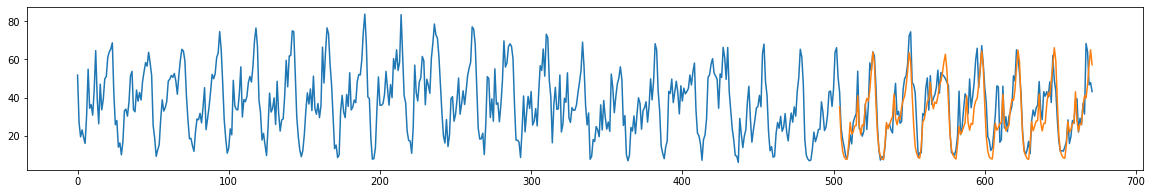

showing plots for kpi PUSCH
MAPE: tf.Tensor(15.094656, shape=(), dtype=float32)


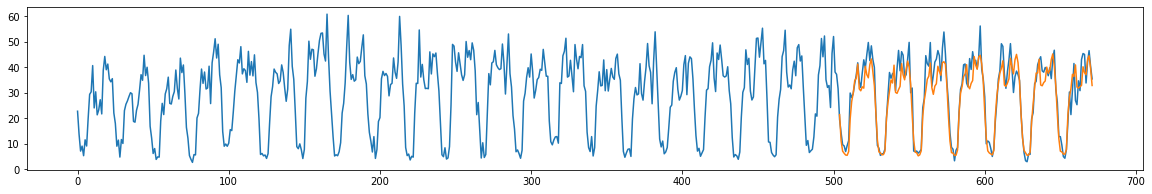

MAPE: tf.Tensor(20.578627, shape=(), dtype=float32)


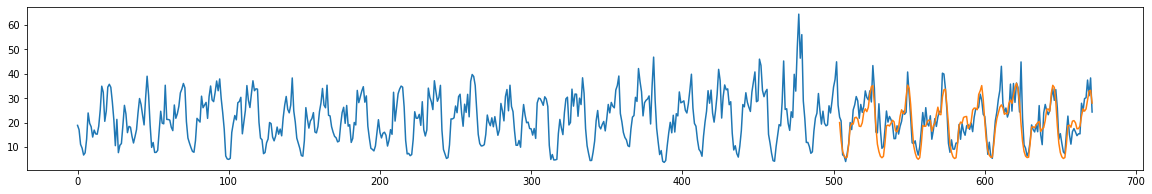

MAPE: tf.Tensor(23.815191, shape=(), dtype=float32)


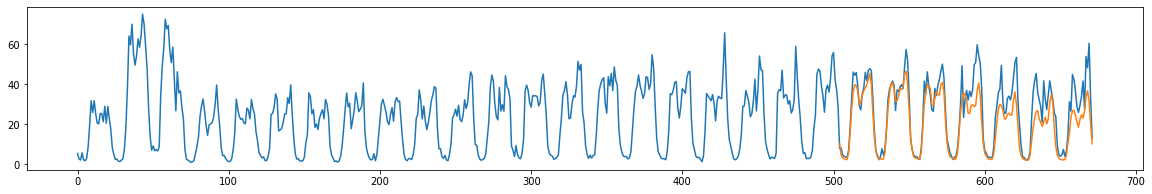

MAPE: tf.Tensor(27.71304, shape=(), dtype=float32)


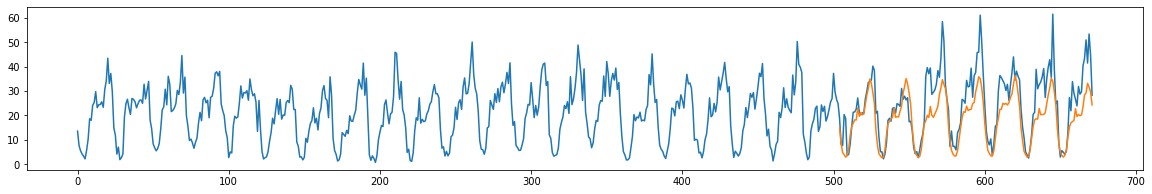

MAPE: tf.Tensor(20.626541, shape=(), dtype=float32)


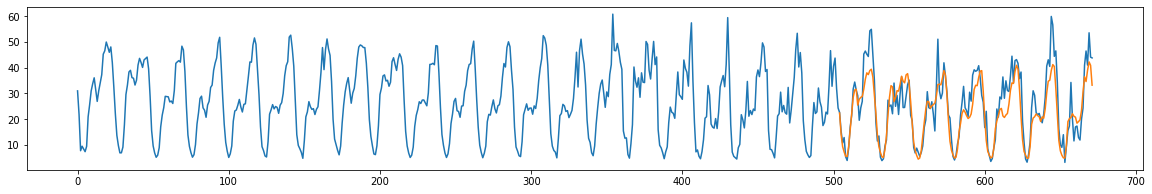

showing plots for kpi RRC
MAPE: tf.Tensor(6.5430775, shape=(), dtype=float32)


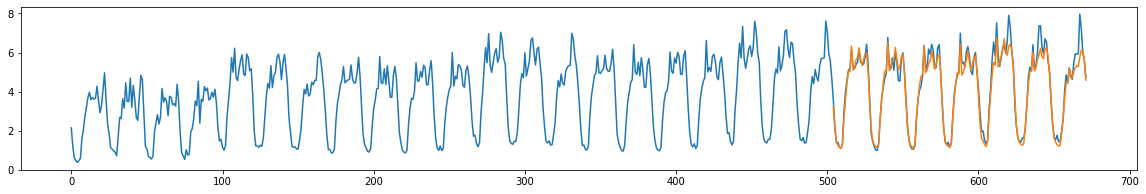

MAPE: tf.Tensor(18.409977, shape=(), dtype=float32)


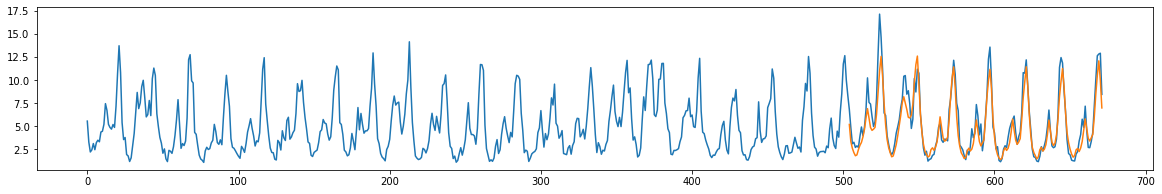

MAPE: tf.Tensor(22.173191, shape=(), dtype=float32)


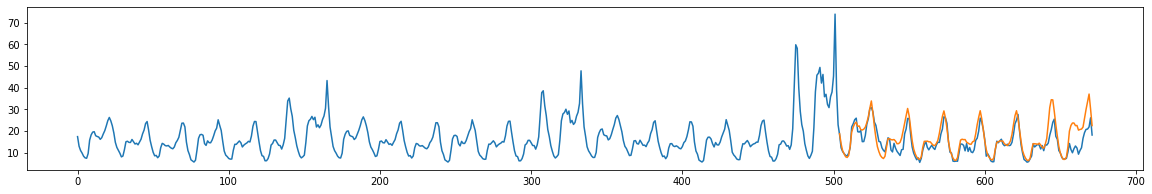

MAPE: tf.Tensor(17.185162, shape=(), dtype=float32)


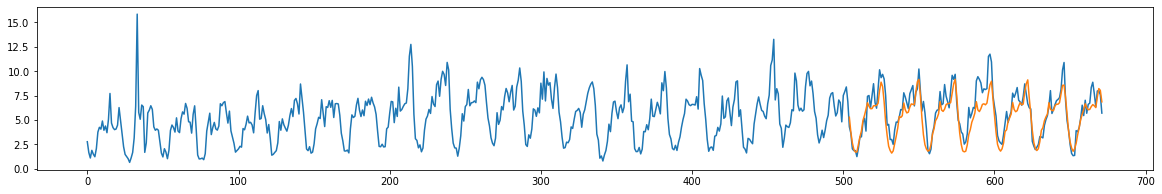

MAPE: tf.Tensor(14.930932, shape=(), dtype=float32)


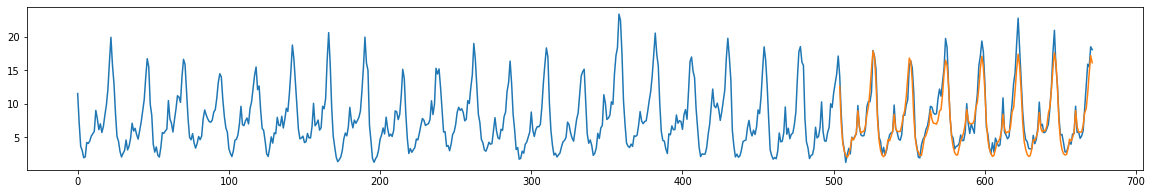

In [7]:
for kpi in kpis:
    print('showing plots for kpi %s' % kpi)
    model = build_compile_model('mse', True)
    model.load_weights('models/4g_%s.h5' % kpi)
    plot_result(model, os.path.join(data_folder, '%s_%s' % ('4g', kpi)))